# Training a CNN 

__Prénom :__ Mohamed  <br>
__Nom :__ Jaouada <br>
__Version de python :__ 3.12.3 <br>
__Machine utilisée :__ Machine personnelle <br>

In [1]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms

import os
#os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
#os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.Pad(2),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# size of the mini batch
minibatchsize = 32

datadir = 'data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform)

#split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000,10000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

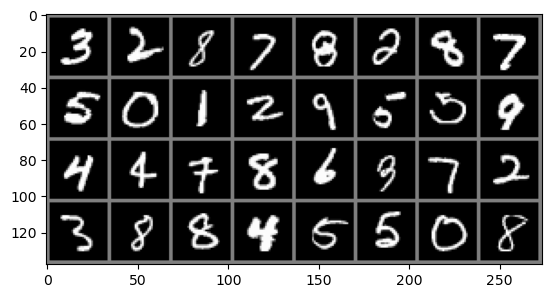

    3     2     8     7


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(name)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Define a CNN

Propose a CNN constructor that takes meta-parameters as arguments (nb conv layers, nb kernel per conv, nb FC layers, nb hidden cells per fc)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# this class define the CNN architecture
# default architecture is close to LeNet5 one
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x


Below is a CNN constructor that accepts hyperparameters as inputs, allowing flexible configuration of: <br>
__-Convolutional layers:__ Defined by lists specifying each layer's: <br>
&nbsp; * out_channels (number of output channels) <br>
&nbsp; * kernel_size<br>
&nbsp; * padding<br>
__-Fully Connected (FC) layers:__ Defined by a list of out_features (dimensionality of each layer's output)<br>
__-Dropout:__ A boolean flag to enable/disable dropout after the first FC layer (if multiple FC layers exist).

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, 
                 conv_layers=[(6, 5, 0), (16, 5, 0)],
                 fc_layers=[120, 84],
                 dropout=False):
        super(CustomCNN, self).__init__()

        self.conv_blocks = nn.ModuleList()
        in_channels = 1

        # Couches de convolution
        for out_channels, kernel_size, padding in conv_layers:
            self.conv_blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            in_channels = out_channels

        self.pool = nn.MaxPool2d(2, 2)

        # Dummy pass pour calculer le nombre de neurones visibles par la premiere couche dense
        dummy_input = torch.zeros(1, 1, 32, 32)
        x = dummy_input
        for conv in self.conv_blocks:
            x = self.pool(F.relu(conv(x)))
        self.flattened_size = x.view(1, -1).shape[1]

        # Couches denses
        self.fc_blocks = nn.ModuleList()
        in_features = self.flattened_size

        self.use_dropout = dropout
        self.dropout = nn.Dropout(0.5) if dropout else None

        for i, hidden_units in enumerate(fc_layers):
            self.fc_blocks.append(nn.Linear(in_features, hidden_units))
            in_features = hidden_units

        self.output_layer = nn.Linear(in_features, 10)

    def forward(self, x):
        for conv in self.conv_blocks:
            x = self.pool(F.relu(conv(x)))

        x = x.view(-1, self.flattened_size)

        for i, fc in enumerate(self.fc_blocks):
            x = F.relu(fc(x))
            # Appliquer dropout (seulement apres la premiere couche dense si elle est suivie par une autre couche dense)
            if i == 0 and self.use_dropout and len(self.fc_blocks) > 1:
                x = self.dropout(x)
        # Pas besoin de x = F.softmax(x, dim=1) car nous utilisons la fonction de perte CrossEntropyLoss qui, selon la documentation de PyTorch, applique déjà log_softmax à l'entrée qu'elle reçoit avant d'appliquer NLLLoss
        x = self.output_layer(x)
        
        return x


In [ ]:
# Define the network to use :
net = NetCNN()
net.to(device) # move it to GPU or CPU
# show the structure :
print(net)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Define a Loss function and optimizer

In [7]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Q1: Optimize the architecture

1. Reuse the training function from the previous TP
2. Analyse your network : recognition rate, confusion matrix 
3. Select one meta-paramter (or 2 depending on the available time) and draw the curve showing the loss depending  on this parameter
4. Evaluate and analyse the best network, compute the number of free parameters (complexity). See documentation of [nn.Module.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters).

## Q2: Draw the Pareto front collectively
Agregate all the results from the group to draw a full Pareto front. Do not hesitate to change the architecture to explore the full tradeoff **complexity/error rate**.

## Q1 :
### 1)

In [ ]:
# Commençant par definir la fonction compute_error() permettant de calculer le taux d'erreur du classifieur (Nb d'individus malclassés/Nb total d'individus) 
def compute_error(loader, net, device):
    total = 0
    correct = 0

    net.eval()  # Mode d'évaluation
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    error_rate = 1 - (correct / total)

    return error_rate

In [ ]:
# Utilisant la même fonction d'entrainement du TP1 :

def train_network(
    net,
    trainloader,
    valloader,
    device="cpu",
    criterion=nn.CrossEntropyLoss(),
    optimizer=None,
    num_epochs=5,
    num_batches_per_epoch=None,
    patience=5
):
    """
    Trains a neural network using mini-batches, tracks error rates and applies early stopping if necessary.

    Parameters:
    - net: Neural network model.
    - trainloader: DataLoader for training set.
    - valloader: DataLoader for validation set.
    - device: Device for computation ('cpu' or 'cuda').
    - criterion: Cross Entropy Loss
    - optimizer: Optimizer (default: SGD).
    - num_epochs: Number of epochs (default: 5).
    - num_batches_per_epoch: Number of mini-batches per epoch (default: full dataset).
    - patience: Early stopping patience (default: 5).

    Returns:
    - best_net: The best trained model.
    - history: A dictionary containing the training history with the following keys:
        - 'train_error': List of training error rates per epoch.
        - 'val_error': List of validation error rates per epoch.
        - 'train_mse': List of mean squared errors on the training set per epoch.
        - 'val_mse': List of mean squared errors on the validation set per epoch.
    """

    net.to(device)
    if optimizer is None:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    best_net = copy.deepcopy(net)
    best_val_error = float("inf")
    best_val_mse = float("inf")
    wait = 0

    # Store metrics for plotting
    history = {"train_error": [], "val_error": []}

    for epoch in range(num_epochs):
        net.train()
        for i, data in enumerate(trainloader):
            if num_batches_per_epoch and i >= num_batches_per_epoch:
                break

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Compute metrics
        train_error = compute_error(trainloader, net, device)
        val_error = compute_error(valloader, net, device)

        history["train_error"].append(train_error)
        history["val_error"].append(val_error)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Error={train_error:.4f}, Val Error={val_error:.4f}")

        # Save the best model (early stopping)
        if val_error < best_val_error :
            best_val_error = min(best_val_error, val_error)
            best_net = copy.deepcopy(net)
            print("Best model saved !")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered !")
                break

    return best_net, history

In [ ]:
# Ajoutant la fonction permettant de tracer les courbes de taux d'erreur en entrainement et en validation
def plot_learning_curves(history):
    """Plots training and validation error rates over epochs to visualize model performance and detect potential issues like 
    overfitting or underfitting."""
    plt.figure(figsize=(12, 5))

    # Error Rate Curve
    plt.subplot(1, 2, 1)
    plt.plot(history["train_error"], label="Train Error", marker="o")
    plt.plot(history["val_error"], label="Validation Error", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Error Rate")
    plt.title("Error Rate Curve")
    plt.legend()
    plt.grid()

    plt.show()

Epoch 1/5: Train Error=0.8869, Val Error=0.8913
Best model saved !
Epoch 2/5: Train Error=0.8869, Val Error=0.8913
Epoch 3/5: Train Error=0.8869, Val Error=0.8913
Epoch 4/5: Train Error=0.8857, Val Error=0.8902
Best model saved !
Epoch 5/5: Train Error=0.8283, Val Error=0.8339
Best model saved !


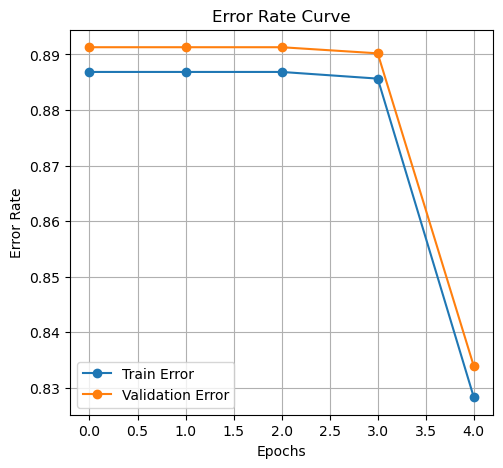

In [ ]:
# Choisir le modèle à utiliser :
net = NetCNN()
net.to(device)
# on entraine le modele en faisant appel à la fonction train_network()
best_model, history = train_network(net, trainloader, validationloader)
# Tracer les courbes de taux d'erreur en entrainement et en validation
plot_learning_curves(history)

### 2)

In [ ]:
# Pour calculer le recognition rate et construire la matrice de confusion et le rapport de classification : 
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_network(net, testloader):
    """
    Evaluates the network on a test set, plots the confusion matrix and returns a classification report.

    Parameters:
    - net: Trained neural network.
    - testloader: DataLoader for test set.

    Returns:
    - accuracy: Recognition rate in percentage.
    - confusion_matrix
    - classification_report.
    """
    net.eval()  # Mode evaluation

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_names = [str(i) for i in range(10)]

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Predire la classe correspondante à la probabilité la plus élevée

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculer l'accuracy
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Recognition Rate (Accuracy): {accuracy:.2f}%")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Classification report, a utiliser pour la question 4
    cr = classification_report(all_labels, all_preds, zero_division=0)

    # Afficher la confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, cm, cr

Recognition Rate (Accuracy): 17.72%


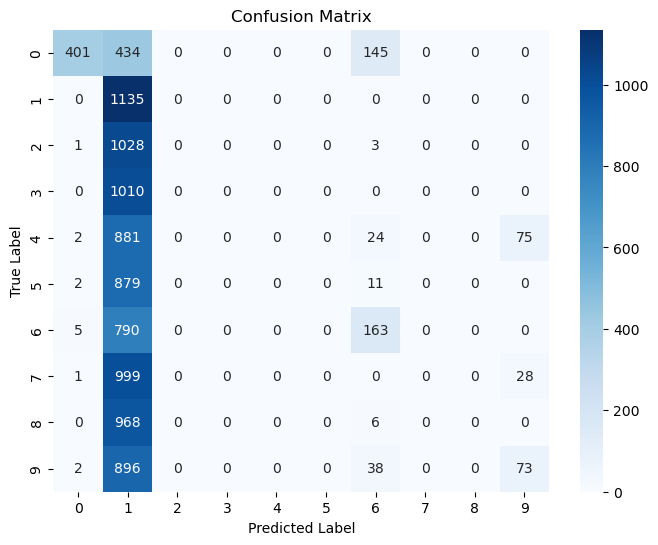

In [19]:
# Faire appel à la fonction evaluate_network()
accuracy, cm, cr = evaluate_network(net, testloader)

### 3) 
Les hyper-parametres choisis sont learning rate et batch size


======== Training with learning rate = 0.001 ========
Epoch 1/5: Train Error=0.8960, Val Error=0.8969
Best model saved !
Epoch 2/5: Train Error=0.8960, Val Error=0.8969
Epoch 3/5: Train Error=0.8960, Val Error=0.8969
Epoch 4/5: Train Error=0.8548, Val Error=0.8567
Best model saved !
Epoch 5/5: Train Error=0.7987, Val Error=0.8047
Best model saved !

======== Training with learning rate = 0.01 ========
Epoch 1/5: Train Error=0.6814, Val Error=0.6852
Best model saved !
Epoch 2/5: Train Error=0.2275, Val Error=0.2263
Best model saved !
Epoch 3/5: Train Error=0.2178, Val Error=0.2206
Best model saved !
Epoch 4/5: Train Error=0.2144, Val Error=0.2176
Best model saved !
Epoch 5/5: Train Error=0.1293, Val Error=0.1288
Best model saved !

======== Training with learning rate = 0.1 ========
Epoch 1/5: Train Error=0.9032, Val Error=0.8994
Best model saved !
Epoch 2/5: Train Error=0.9032, Val Error=0.8994
Epoch 3/5: Train Error=0.9032, Val Error=0.8994
Epoch 4/5: Train Error=0.9032, Val Error=0.

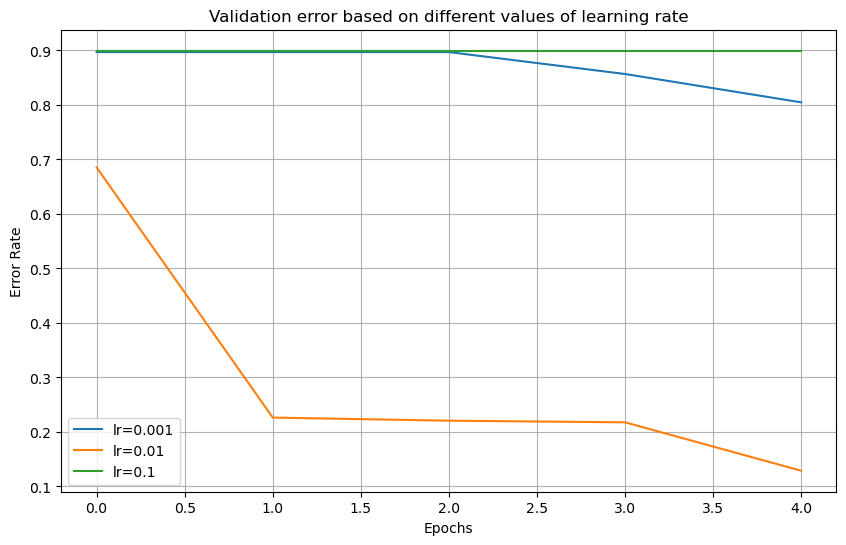

In [ ]:
# Liste des learning rates à tester
learning_rates = [0.001, 0.01, 0.1]
loss_results = {}

for lr in learning_rates:
    print(f"\n======== Training with learning rate = {lr} ========")

    # Création d'une nouvelle instance du modèle
    net = NetCNN()

    # Définition de l'optimiseur avec le learning rate courant
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    # Entraînement du modèle avec la fonction train_network existante
    _, history = train_network(net, trainloader, validationloader, optimizer=optimizer, num_epochs=5)

    # Stocker les pertes (tu peux aussi stocker les erreurs ou MSE selon ce que tu veux tracer)
    loss_results[lr] = history["val_error"]  # ou "train_error" ou "train_mse"

# Tracer les courbes comparatives
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(loss_results[lr], label=f"lr={lr}")

plt.title("Validation error based on different values of learning rate")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.legend()
plt.grid(True)
plt.show()


======== Training with batch size = 16 ========
Epoch 1/5: Train Error=0.1978, Val Error=0.2014
Best model saved !
Epoch 2/5: Train Error=0.1226, Val Error=0.1290
Best model saved !
Epoch 3/5: Train Error=0.0372, Val Error=0.0401
Best model saved !
Epoch 4/5: Train Error=0.0320, Val Error=0.0373
Best model saved !
Epoch 5/5: Train Error=0.0311, Val Error=0.0358
Best model saved !

======== Training with batch size = 32 ========
Epoch 1/5: Train Error=0.7018, Val Error=0.7017
Best model saved !
Epoch 2/5: Train Error=0.2306, Val Error=0.2300
Best model saved !
Epoch 3/5: Train Error=0.2248, Val Error=0.2267
Best model saved !
Epoch 4/5: Train Error=0.1364, Val Error=0.1429
Best model saved !
Epoch 5/5: Train Error=0.1176, Val Error=0.1278
Best model saved !

======== Training with batch size = 64 ========
Epoch 1/5: Train Error=0.7741, Val Error=0.7793
Best model saved !
Epoch 2/5: Train Error=0.2444, Val Error=0.2498
Best model saved !
Epoch 3/5: Train Error=0.1606, Val Error=0.1659
B

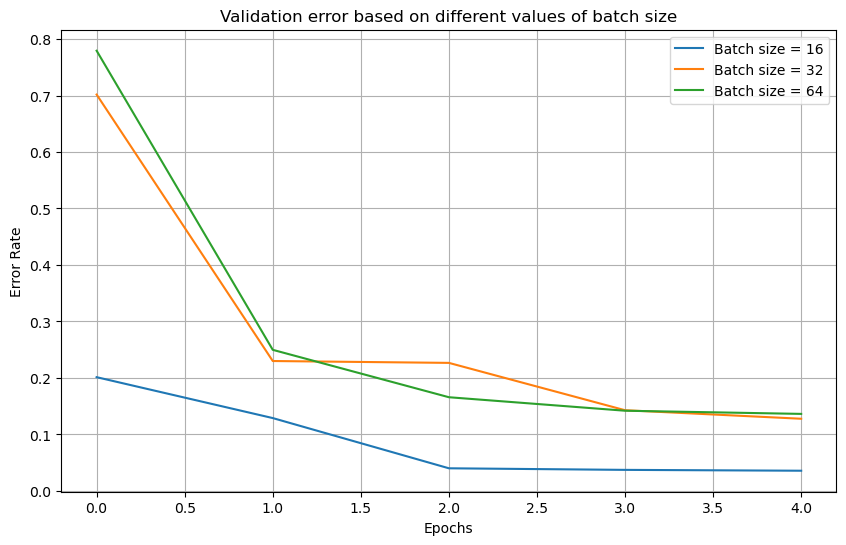

In [27]:
batch_sizes = [16, 32, 64]
histories_by_batchsize = {}

for bs in batch_sizes:
    print(f"\n======== Training with batch size = {bs} ========")

    # Redéfinir les dataloaders pour chaque batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
    valloader = torch.utils.data.DataLoader(validationset, batch_size=bs, shuffle=False, num_workers=0)

    # Nouvelle instance du modèle et optimizer
    net = NetCNN()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    # Entraîner le réseau
    _, history = train_network(net, trainloader, valloader, optimizer=optimizer, num_epochs=5)
    
    # Stocker les courbes
    histories_by_batchsize[bs] = history

plt.figure(figsize=(10, 6))
for bs in batch_sizes:
    plt.plot(histories_by_batchsize[bs]["val_error"], label=f"Batch size = {bs}")

plt.title("Validation error based on different values of batch size")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
############ Attention ! ça peut durer environ 17 minutes pour faire tout le Grid Search !
# On fait maintenant un Grid Search pour trouver la meilleur combinaison des valeurs des deux hyper-parametres learning rate et batch size (qui donne le meilleur taux d'erreur de validation)
# Paramètres à tester
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Pour sauvegarder le meilleur modèle et sa val_loss
best_val_loss = float("inf")
best_model = None
best_hyperparams = {}

# Grid search
for batch_size in batch_sizes:
    print(f"\n====== Batch size: {batch_size} ======")
    
    # Création des DataLoaders pour cette taille de batch
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for lr in learning_rates:
        print(f"Training with learning rate={lr} and batch size={batch_size}")

        # Nouveau modèle et optimiseur
        model = NetCNN()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Entraînement
        _, history = train_network(
            net=model,
            trainloader=trainloader,
            valloader=valloader,
            optimizer=optimizer,
            num_epochs=5
        )

        val_loss = history["val_error"][-1]

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_hyperparams = {"lr": lr, "batch_size": batch_size}
            print("New best model and best hyper-parameter values saved !")

print("\n Grid Search complete !")
print(f"Best hyper-parameter values : Learning Rate={best_hyperparams['lr']} | Batch Size={best_hyperparams['batch_size']}")
print(f"Best validation error : {best_val_loss:.4f}")

# Sauvegarde du modèle
torch.save(best_model.state_dict(), "best_model.pth")
print("Model saved in 'best_model.pth'")



====== Batch size: 16 ======
Training with learning rate=0.001 and batch size=16
Epoch 1/5: Train Error=0.9052, Val Error=0.9012
Best model saved !
Epoch 2/5: Train Error=0.8029, Val Error=0.8034
Best model saved !
Epoch 3/5: Train Error=0.7971, Val Error=0.7998
Best model saved !
Epoch 4/5: Train Error=0.8476, Val Error=0.8516
Epoch 5/5: Train Error=0.3192, Val Error=0.3225
Best model saved !
New best model and best hyper-parameter values saved !
Training with learning rate=0.01 and batch size=16
Epoch 1/5: Train Error=0.2209, Val Error=0.2228
Best model saved !
Epoch 2/5: Train Error=0.1714, Val Error=0.1789
Best model saved !
Epoch 3/5: Train Error=0.1325, Val Error=0.1389
Best model saved !
Epoch 4/5: Train Error=0.1230, Val Error=0.1296
Best model saved !
Epoch 5/5: Train Error=0.1173, Val Error=0.1256
Best model saved !
New best model and best hyper-parameter values saved !
Training with learning rate=0.1 and batch size=16
Epoch 1/5: Train Error=0.8869, Val Error=0.8913
Best mod

### 4) 
Evaluons et analysons maintenant le meilleur modèle qu'on a pu trouver jusqu'à present 

Recognition Rate (Accuracy): 88.87%


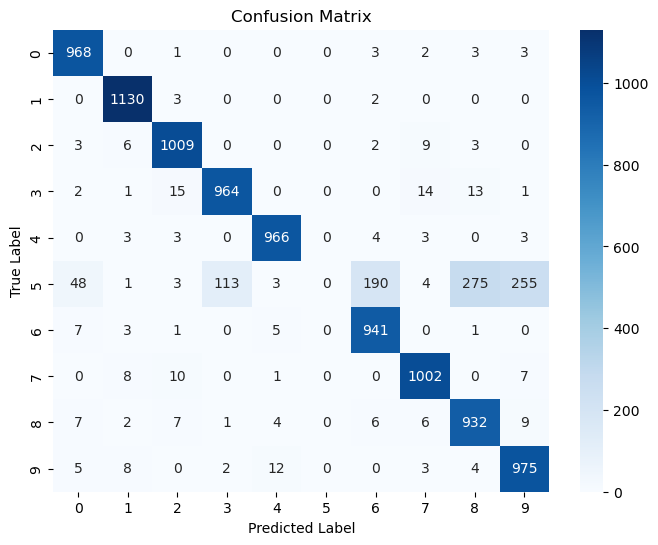


 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.97      1.00      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.89      0.95      0.92      1010
           4       0.97      0.98      0.98       982
           5       0.00      0.00      0.00       892
           6       0.82      0.98      0.89       958
           7       0.96      0.97      0.97      1028
           8       0.76      0.96      0.85       974
           9       0.78      0.97      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.80      0.88      0.84     10000
weighted avg       0.82      0.89      0.85     10000



In [ ]:
# Faire appel à la fonction evaluate_network() pour evaluer le modèle obtenu
model = NetCNN()
model.load_state_dict(torch.load("best_model.pth"))
accuracy, cm, cr = evaluate_network(model, testloader)

print("\n Classification Report:")
print(cr)

In [ ]:
# On defini ici une fonction qui permet de calculer le nombre de parametres libres (poids) d'un reseau de neurones 
def count_trainable_parameters(net):
    """
    Counts the total number of trainable parameters in a neural network.

    Parameters:
    - net: model.

    Returns:
    - total_params: Total number of trainable parameters.
    - details: List of parameter counts per layer.
    """
    total_params = 0
    details = []

    for name, param in net.named_parameters():
        if param.requires_grad:  # Vérifie si le paramètre est entraînable
            num_params = param.numel()  # Nombre total d'éléments
            total_params += num_params
            details.append(f"{name}: {num_params} parameters")

    print("\n Detailed breakdown of trainable parameters :")
    for detail in details:
        print(detail)

    print(f"\n Total number of trainable parameters : {total_params}")
    return total_params, details

In [ ]:
# Calculons le nombre de poids ainsi que le taux d'erreur sur le dataset de test du meilleur modèle qu'on a jusqu'à present
# Appel à la fonction count_trainable_parameters() : 
total_params, _ = count_trainable_parameters(model)
print(f"\n Total number of trainable parameters : {total_params} \n Error Rate : {100-accuracy}")


 Detailed breakdown of trainable parameters :
conv1.weight: 150 parameters
conv1.bias: 6 parameters
conv2.weight: 2400 parameters
conv2.bias: 16 parameters
fc1.weight: 48000 parameters
fc1.bias: 120 parameters
fc2.weight: 10080 parameters
fc2.bias: 84 parameters
fc3.weight: 840 parameters
fc3.bias: 10 parameters

 Total number of trainable parameters : 61706

 Total number of trainable parameters : 61706 
 Error Rate : 11.129999999999995


### Q2 : 
- L'objectif que je me suis fixé ici est d'atteindre le taux d'erreur le plus faible possible, tout en maintenant une complexité suffisamment basse pour que mon modèle se situe sur le front de Pareto.
J'ai donc essayé de modifier l'architecture du CNN afin d'améliorer les résultats et d'explorer le compromis entre complexité et taux d'erreur.

- Pour pouvoir comparer différentes architectures de CNN, j'ai défini une fonction permettant de construire dynamiquement un CNN à partir des hyperparamètres fournis en argument.
Cette fonction, nommée CustomCNN(), a été définie au début de ce TP.


 Testing architecture : SimpleCNN
Epoch 1/5: Train Error=0.3649, Val Error=0.3645
Best model saved !
Epoch 2/5: Train Error=0.0965, Val Error=0.0951
Best model saved !
Epoch 3/5: Train Error=0.0585, Val Error=0.0588
Best model saved !
Epoch 4/5: Train Error=0.0481, Val Error=0.0496
Best model saved !
Epoch 5/5: Train Error=0.0403, Val Error=0.0428
Best model saved !


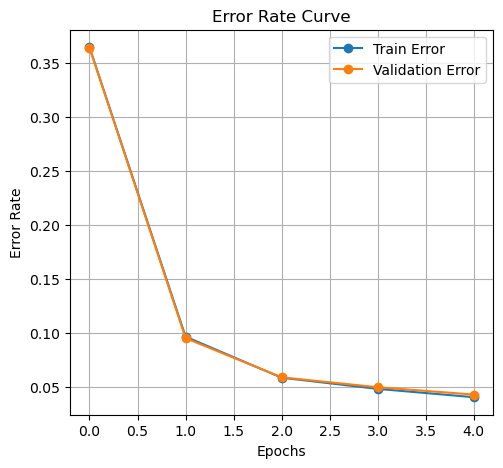

Recognition Rate (Accuracy): 95.82%


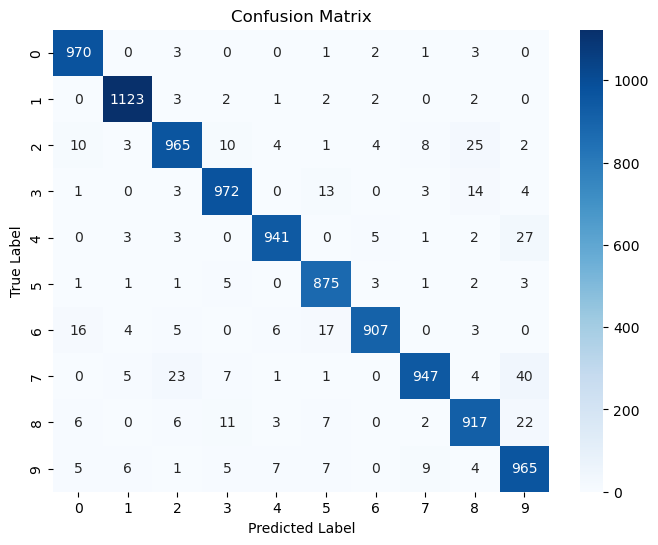


 Detailed breakdown of trainable parameters :
conv_blocks.0.weight: 400 parameters
conv_blocks.0.bias: 16 parameters
conv_blocks.1.weight: 4608 parameters
conv_blocks.1.bias: 32 parameters
fc_blocks.0.weight: 131072 parameters
fc_blocks.0.bias: 64 parameters
output_layer.weight: 640 parameters
output_layer.bias: 10 parameters

 Total number of trainable parameters : 136842
SimpleCNN -> Accuracy: 95.82%, Parameters: 136842, Error rate: 4.18%

 Testing architecture : MediumCNN
Epoch 1/5: Train Error=0.1836, Val Error=0.1852
Best model saved !
Epoch 2/5: Train Error=0.0987, Val Error=0.0991
Best model saved !
Epoch 3/5: Train Error=0.0727, Val Error=0.0721
Best model saved !
Epoch 4/5: Train Error=0.0570, Val Error=0.0573
Best model saved !
Epoch 5/5: Train Error=0.0488, Val Error=0.0491
Best model saved !


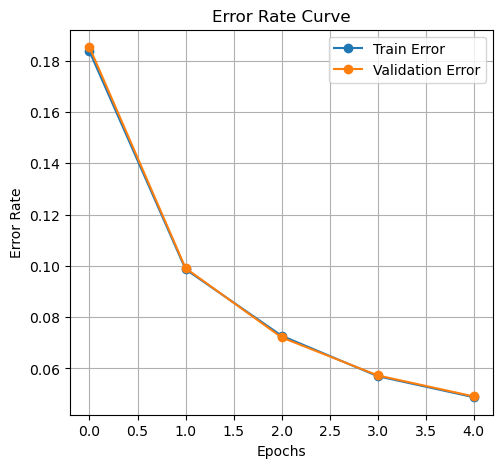

Recognition Rate (Accuracy): 95.31%


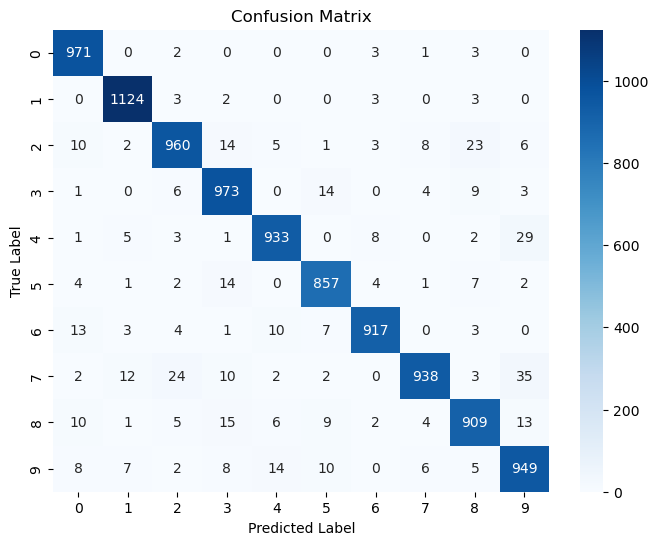


 Detailed breakdown of trainable parameters :
conv_blocks.0.weight: 288 parameters
conv_blocks.0.bias: 32 parameters
conv_blocks.1.weight: 18432 parameters
conv_blocks.1.bias: 64 parameters
fc_blocks.0.weight: 524288 parameters
fc_blocks.0.bias: 128 parameters
output_layer.weight: 1280 parameters
output_layer.bias: 10 parameters

 Total number of trainable parameters : 544522
MediumCNN -> Accuracy: 95.31%, Parameters: 544522, Error rate: 4.69%

 Testing architecture : ComplexCNN
Epoch 1/5: Train Error=0.8869, Val Error=0.8913
Best model saved !
Epoch 2/5: Train Error=0.8869, Val Error=0.8913
Epoch 3/5: Train Error=0.7872, Val Error=0.7890
Best model saved !
Epoch 4/5: Train Error=0.5566, Val Error=0.5565
Best model saved !
Epoch 5/5: Train Error=0.2486, Val Error=0.2536
Best model saved !


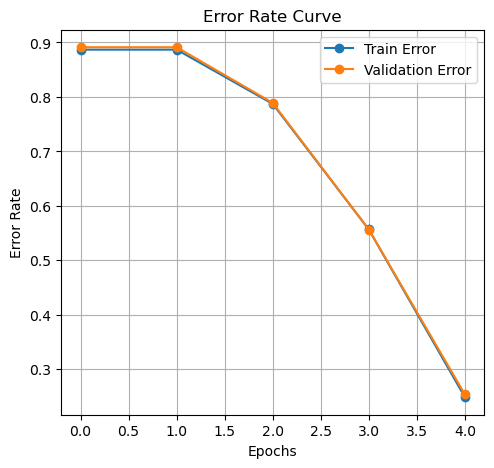

Recognition Rate (Accuracy): 74.94%


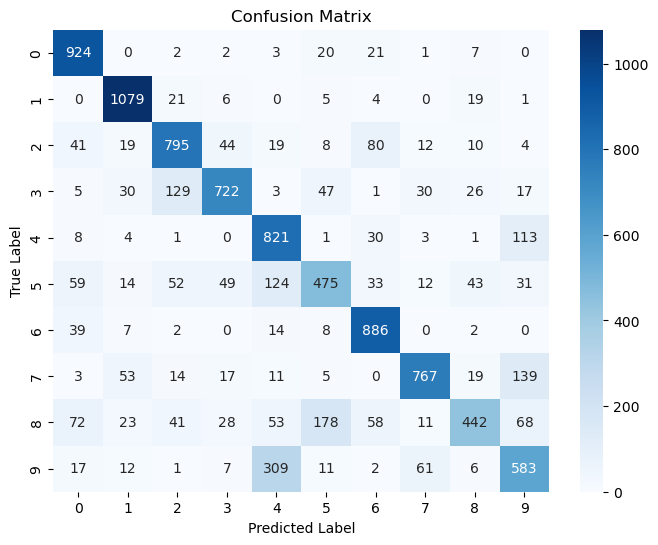


 Detailed breakdown of trainable parameters :
conv_blocks.0.weight: 288 parameters
conv_blocks.0.bias: 32 parameters
conv_blocks.1.weight: 18432 parameters
conv_blocks.1.bias: 64 parameters
conv_blocks.2.weight: 73728 parameters
conv_blocks.2.bias: 128 parameters
fc_blocks.0.weight: 524288 parameters
fc_blocks.0.bias: 256 parameters
fc_blocks.1.weight: 32768 parameters
fc_blocks.1.bias: 128 parameters
output_layer.weight: 1280 parameters
output_layer.bias: 10 parameters

 Total number of trainable parameters : 651402
ComplexCNN -> Accuracy: 74.94%, Parameters: 651402, Error rate: 25.06%

 Best model: SimpleCNN with Accuracy: 95.82%
 Saved to: SimpleCNN_best_model.pt


In [26]:
# Liste des architectures à tester
architectures = [
    {
        "name": "SimpleCNN",
        "conv_layers": [(16, 5, 2), (32, 3, 1)],
        "fc_layers": [64],
        "dropout": False,
    },
    {
        "name": "MediumCNN",
        "conv_layers": [(32, 3, 1), (64, 3, 1)],
        "fc_layers": [128],
        "dropout": True,
    },
    {
        "name": "ComplexCNN",
        "conv_layers": [(32, 3, 1), (64, 3, 1), (128, 3, 1)],
        "fc_layers": [256, 128],
        "dropout": True,
    },
]

# Initialisation
best_accuracy = 0
best_model = None
best_model_name = ""
best_history = None

# Boucle sur les architectures
for config in architectures:
    print(f"\n Testing architecture : {config['name']}")

    # Créer le modèle
    net = CustomCNN(
        conv_layers=config["conv_layers"],
        fc_layers=config["fc_layers"],
        dropout=config["dropout"]
    ).to(device)

    # Optimiseur
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    # Entraînement
    trained_model, history = train_network(net, trainloader, valloader)
    plot_learning_curves(history)

    # Évaluation
    accuracy, cm, cr = evaluate_network(trained_model, testloader)
    total_params, _ = count_trainable_parameters(trained_model)

    print(f"{config['name']} -> Accuracy: {accuracy:.2f}%, Parameters: {total_params}, Error rate: {100 - accuracy:.2f}%")

    # Sauvegarde si c'est le meilleur
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = copy.deepcopy(trained_model)
        best_model_name = config['name']
        best_history = history

# Sauvegarde du meilleur modèle
torch.save(best_model.state_dict(), f"{best_model_name}_best_model.pt")
print(f"\n Best model: {best_model_name} with Accuracy: {best_accuracy:.2f}%")
print(f" Saved to: {best_model_name}_best_model.pt")


- Après avoir testé les trois architectures, qui diffèrent en complexité, on remarque que, bien qu’il soit le réseau le moins complexe des trois, le SimpleCNN, avec 136 842 paramètres libres, est celui qui obtient le taux d’erreur le plus faible, atteignant 4,18 %.

- Afin d'optimiser encore plus le modele SimpleCNN faisons un dernier Grid Search pour trouver la meilleur combinaison des valeurs des deux hyperparametres (learning rate et batch size) -> hyperparameter tuning

In [ ]:
############ Attention ! ça peut durer environ 20 minutes pour faire tout le Grid Search !

# Parametres à tester
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Pour sauvegarder le meilleur modèle et sa val_loss
best_val_loss = float("inf")
best_model = None
best_hyperparams = {}

# Grid search
for batch_size in batch_sizes:
    print(f"\n====== Batch size: {batch_size} ======")
    
    # Création des DataLoaders pour cette taille de batch
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for lr in learning_rates:
        print(f"Training with learning rate={lr} and batch size={batch_size}")

        # Nouveau modèle et optimiseur
        model = CustomCNN(
            conv_layers=[(16, 5, 2), (32, 3, 1)],
            fc_layers=[64],
            dropout= False
        ).to(device)

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Entraînement
        _, history = train_network(
            net=model,
            trainloader=trainloader,
            valloader=valloader,
            optimizer=optimizer,
            num_epochs=5
        )

        val_loss = history["val_error"][-1]

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_hyperparams = {"lr": lr, "batch_size": batch_size}
            print("New best model and best hyper-parameter values saved !")

print("\n Grid Search complete !")
print(f"Best hyper-parameter values : Learning Rate={best_hyperparams['lr']} | Batch Size={best_hyperparams['batch_size']}")
print(f"Best validation error : {best_val_loss:.4f}")

# Sauvegarde du modèle
torch.save(best_model.state_dict(), "Final_best_model.pth")
print("Model saved in 'Final_best_model.pth'")


====== Batch size: 16 ======
Training with learning rate=0.001 and batch size=16
Epoch 1/5: Train Error=0.0541, Val Error=0.0568
Best model saved !
Epoch 2/5: Train Error=0.0359, Val Error=0.0404
Best model saved !
Epoch 3/5: Train Error=0.0258, Val Error=0.0274
Best model saved !
Epoch 4/5: Train Error=0.0212, Val Error=0.0257
Best model saved !
Epoch 5/5: Train Error=0.0182, Val Error=0.0242
Best model saved !
New best model and best hyper-parameter values saved !
Training with learning rate=0.01 and batch size=16
Epoch 1/5: Train Error=0.0224, Val Error=0.0276
Best model saved !
Epoch 2/5: Train Error=0.0169, Val Error=0.0246
Best model saved !
Epoch 3/5: Train Error=0.0075, Val Error=0.0169
Best model saved !
Epoch 4/5: Train Error=0.0070, Val Error=0.0144
Best model saved !
Epoch 5/5: Train Error=0.0062, Val Error=0.0156
New best model and best hyper-parameter values saved !
Training with learning rate=0.1 and batch size=16
Epoch 1/5: Train Error=0.8951, Val Error=0.8933
Best mod

Recognition Rate (Accuracy): 98.60%


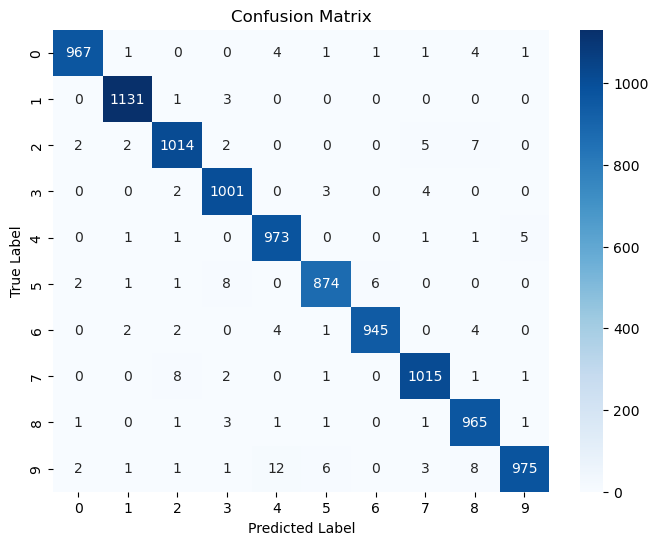


 Detailed breakdown of trainable parameters :
conv_blocks.0.weight: 400 parameters
conv_blocks.0.bias: 16 parameters
conv_blocks.1.weight: 4608 parameters
conv_blocks.1.bias: 32 parameters
fc_blocks.0.weight: 131072 parameters
fc_blocks.0.bias: 64 parameters
output_layer.weight: 640 parameters
output_layer.bias: 10 parameters

 Total number of trainable parameters : 136842

 Error Rate : 1.4000000000000057 
 With Hyper-parameters : 
 Learning Rate = 0.01 
 Batch size = 16

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
          

In [32]:
# Faire appel à la fonction evaluate_network() pour evaluer le modèle obtenu
model = CustomCNN(
        conv_layers=[(16, 5, 2), (32, 3, 1)],
        fc_layers=[64],
        dropout= False
).to(device)
model.load_state_dict(torch.load("Final_best_model.pth"))
accuracy, cm, cr = evaluate_network(model, testloader)
total_params, _ = count_trainable_parameters(model)
print(f"\n Error Rate : {100-accuracy} \n With Hyper-parameters : \n Learning Rate = 0.01 \n Batch size = 16")
print("\n Classification Report:")
print(cr)

## Conclusion :
- Error Rate = 1.4 <br>
- Complexité = 136842 poids <br>
- Après le réglage des hyperparamètres, le meilleur modèle final obtenu est SimpleCNN, qui présente l'architecture la plus simple parmi les trois modèles testés. Ce résultat a été obtenu après un entraînement avec un taux d’apprentissage de 0,01 et une taille de batch de 16. <br>
Ces résultats permettent de conclure qu’un modèle plus complexe n’est pas nécessairement plus performant. Le tuning des hyperparamètres joue un rôle essentiel dans l’obtention de bons résultats et permet à un modèle d’atteindre son plein potentiel.